1.0 [4, 15, 7, 7, 18, 5, 6, 11, 8, 19]


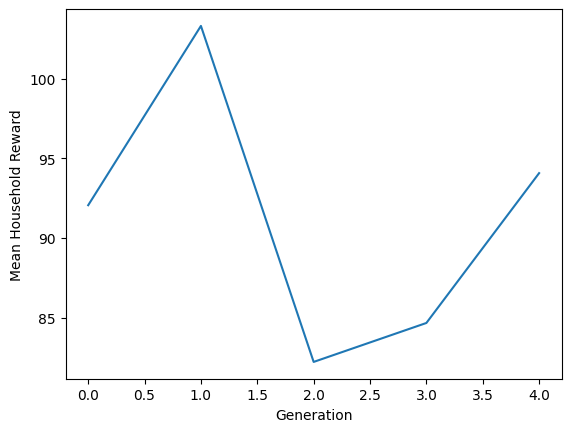

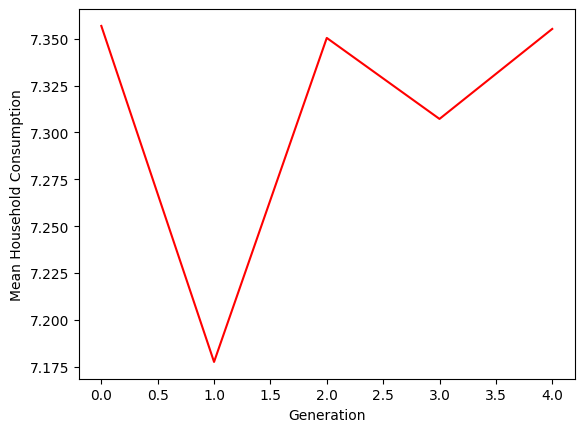

1.0 [5, 21, 7, 7, 20, 6, 6, 12, 7, 9]


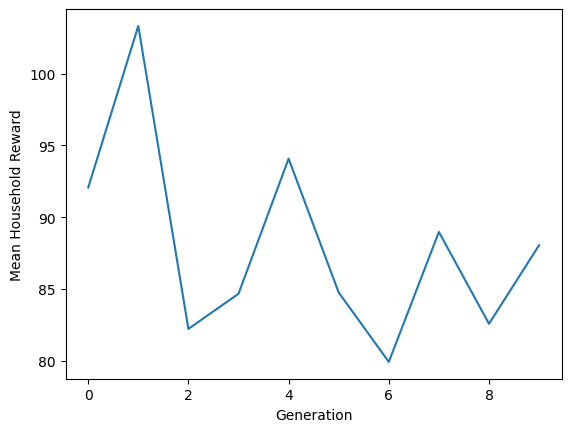

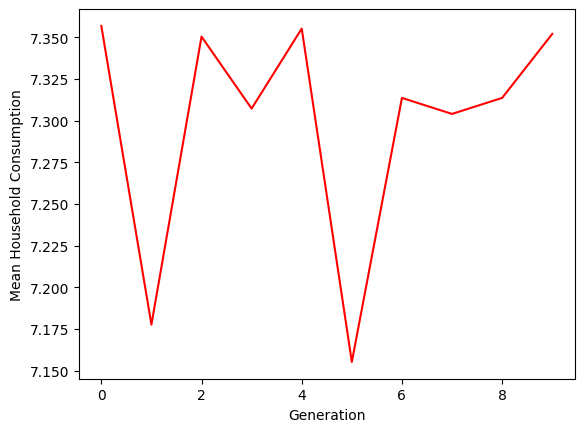

1.0 [4, 16, 13, 8, 10, 8, 12, 12, 7, 10]


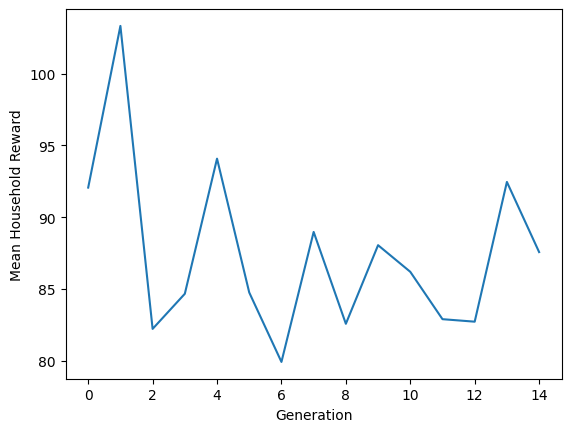

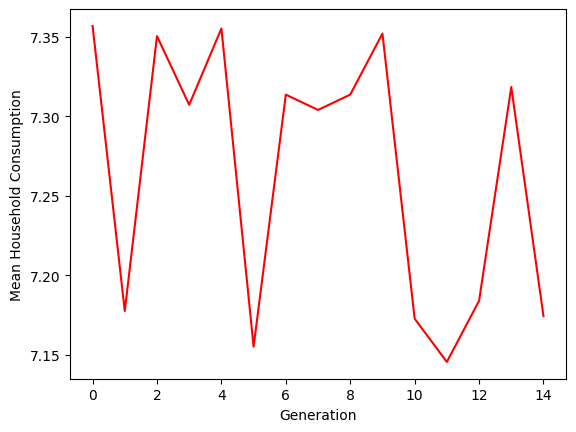

1.0 [4, 18, 8, 7, 14, 9, 7, 12, 9, 12]


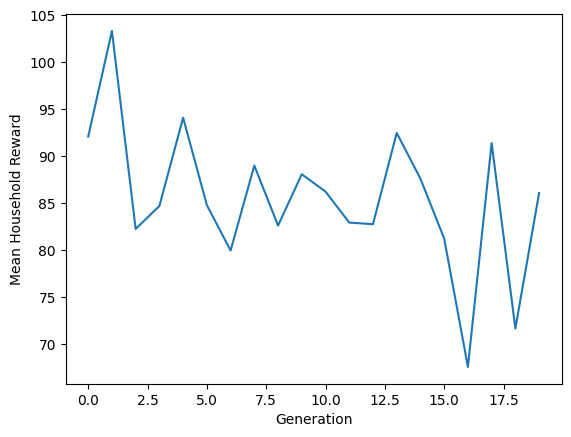

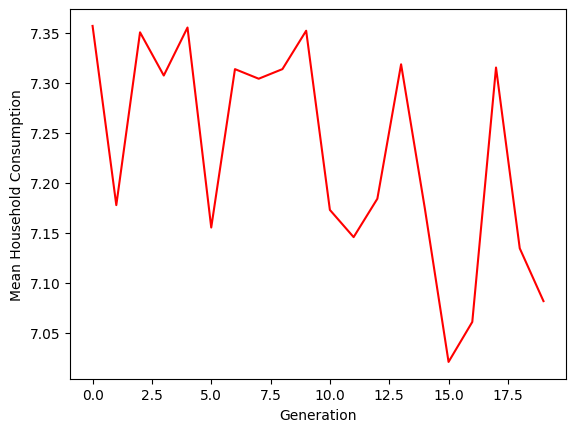

1.0 [4, 16, 8, 7, 18, 5, 6, 10, 7, 19]


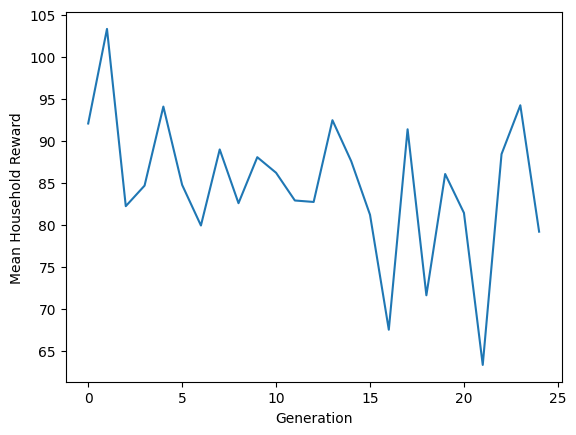

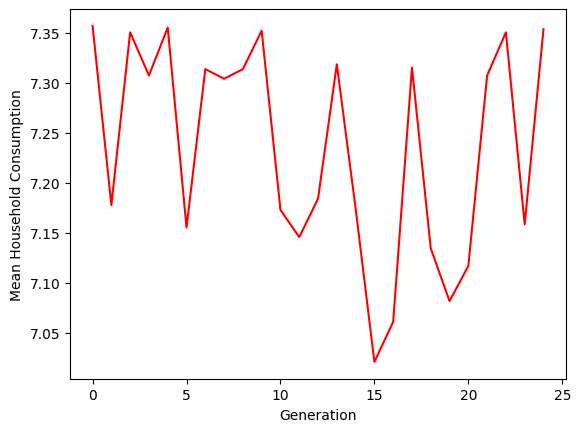

0.99 [5, 35, 7, 6, 8, 6, 7, 10, 6, 9]


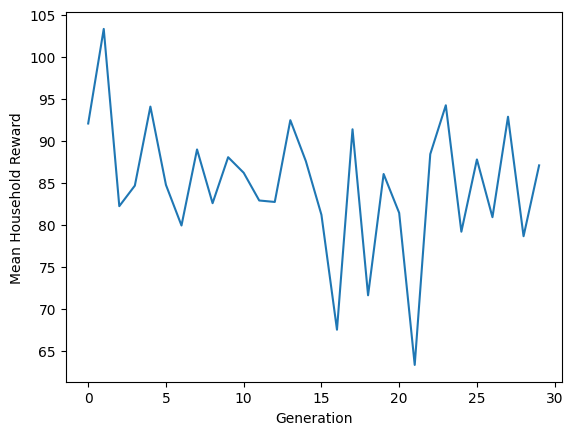

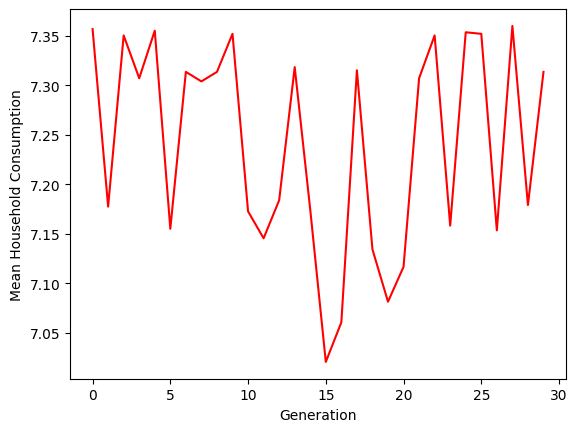

0.99 [5, 23, 7, 6, 10, 6, 7, 11, 6, 18]


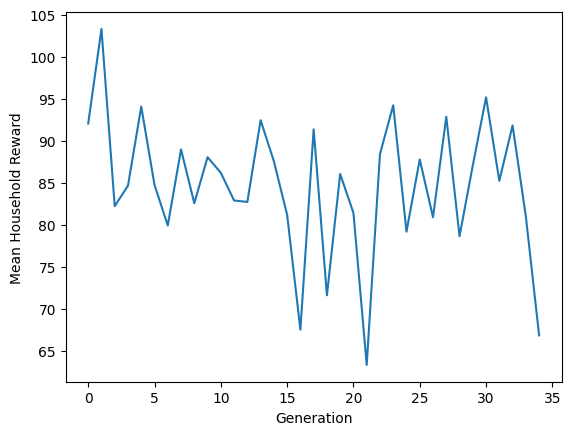

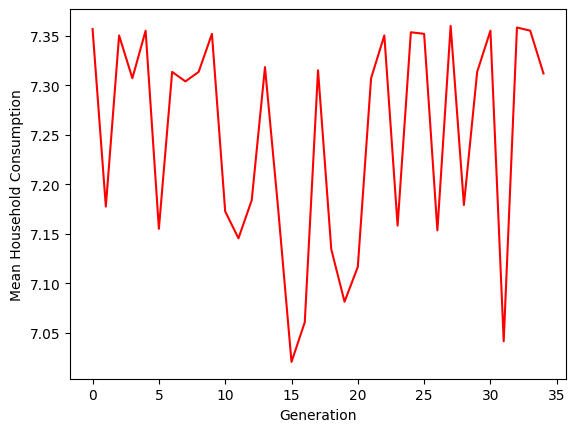

1.0 [4, 14, 7, 7, 9, 6, 7, 20, 17, 9]


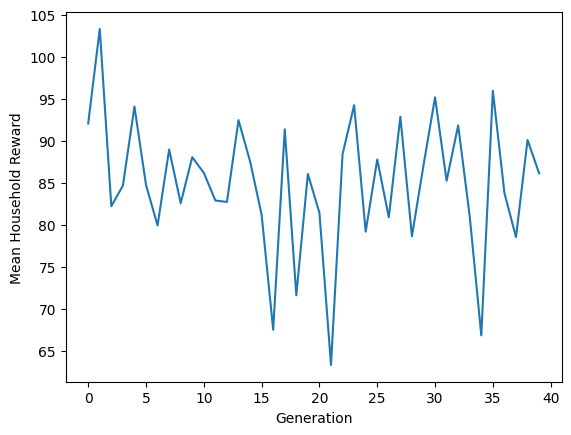

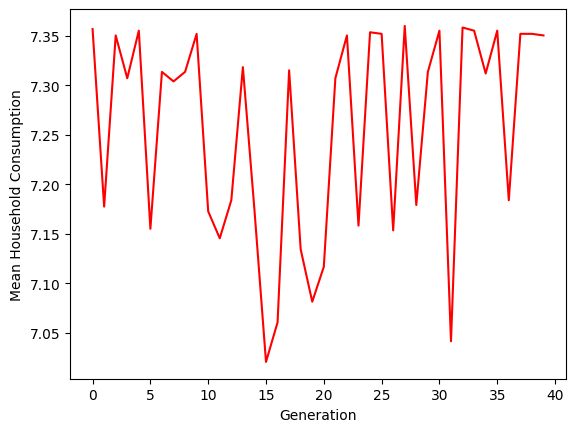

1.0 [4, 20, 8, 7, 15, 7, 6, 12, 7, 14]


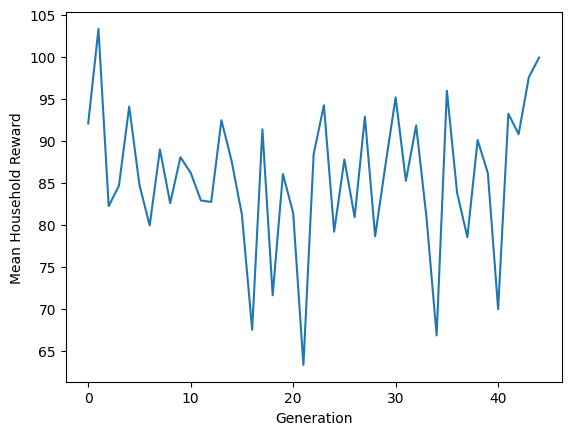

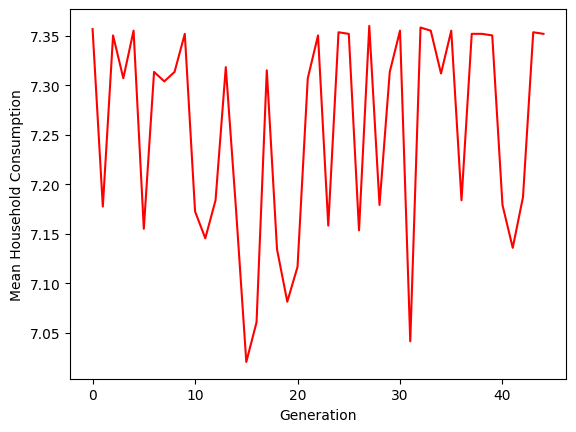

KeyboardInterrupt: 

In [ ]:
import numpy as np

class Household:
    def __init__(self, i, num_firms):
        self.i = i
        self.savings = 0
        self.income = 0

        input_len = 5 + num_firms # savings, income, interest rate, tax rate, tax credit, prices
        output_len = 1

        self.w = np.random.uniform(-1, 1, (input_len, output_len))
        self.b = np.random.uniform(-1, 1, output_len)

        # in order to speed up the GA, keep track of which genes were changed by how much since the last iteration
        # we can then consider (for a high-reward house) these genes to be of high importance
        #self.w_deltas = np.zeros_like(self.w)
        #self.b_deltas = np.zeros_like(self.b)

        self.reward = 0

    # make sure the act() doesn't output out-of-domain values!!!!!
    def act(self):
        global bank, gov, firms, skill_matrix

        prices = [firm.price for firm in firms]

        input = np.array([self.savings, self.income, bank.interest_rate, gov.tax_rate_house, gov.tax_credits[self.i]] + prices)

        self.goods_requested = np.maximum(0, input @ self.w + self.b) * np.array(prices) / np.mean(prices)

    def step(self):
        global houses, firms, bank, gov, employment_matrix, skill_matrix, hiring_firms

        # starting out, or if we were laid off
        if sum([employment_matrix[self.i][j] for j, _ in enumerate(firms)]) == 0:
            if hiring_firms:
                # of the hiring firms, pick the one i'm best at
                j = max(hiring_firms, key=lambda x: skill_matrix[self.i][x])
                employment_matrix[self.i][j] = 1
                self.wage = firms[j].wage
            else:
                self.wage = 0

        self.goods_received = [
            min(
                self.goods_requested[j],
                (firm.inventory + firm.production) * self.goods_requested[j] / tot if (tot := sum([house.goods_requested[j] for house in houses])) else 0
            )
            for j, firm in enumerate(firms)
        ]

        expenditure = sum([self.goods_received[j] * firm.price for j, firm in enumerate(firms)])

        self.income = self.wage * labour_hours
        self.savings += bank.interest_rate * self.savings + self.income - expenditure - gov.tax_rate_house * self.income + gov.tax_credits[self.i]

    def comp_reward(self):
        gamma = 0.5  # risk aversion coefficient
        nu = 0 # weight on labour disutility
        mu = 1 # weight on savings utility

        def utility(x):
            # incase fp inaccuracies
            if x <= 0:
                return 0
            return (x ** (1 - gamma)) / (1 - gamma)

        self.consumption = sum(self.goods_received)
        hours = labour_hours if self.wage > 0 else 0

        # CURRENTLY DISCOUNTING CONSUMPTION UTILITY
        self.reward = 0 * utility(self.consumption) - nu * hours ** 2 + mu * (1 if self.savings > 0 else -1) * utility(abs(self.savings))


# TODO add exogenous shocks
class Firm:
    def __init__(self, i, wage, price):
        self.i = i
        self.wage = wage
        self.price = price
        self.production = 0
        self.inventory = 0
        self.deposit = 0

        self.consumption_history = []

    # make sure the act() doesn't output out-of-domain values!!!!!
    def act(self):
        # self.price = ...
        # self.wage = ...
        pass

    def forecast_demand(self):
        # simple moving average of last 4 quarters for now
        return sum(self.consumption_history[-4:]) / 4 if len(self.consumption_history) >= 4 else sum(self.consumption_history) / len(self.consumption_history) if self.consumption_history else 0

    def step(self):
        global houses, bank, gov, employment_matrix, skill_matrix

        consumption = sum([house.goods_received[self.i] for house in houses])
        num_employees = sum([employment_matrix[j][self.i] for j, _ in enumerate(houses)])

        # to avoid fp inaccuracies in the case where all of inventory + production was consumed
        self.inventory = max(0, self.inventory + self.production - consumption)
        self.production = (labour_hours * num_employees) ** alpha

        revenue = sum([house.goods_received[self.i] * self.price for house in houses])
        expenditure = self.wage * labour_hours * num_employees

        self.profit = revenue - expenditure
        self.deposit += bank.interest_rate * self.deposit + self.profit - gov.tax_rate_firm * max(0, self.profit)

        # hiring/firing
        self.consumption_history.append(consumption)
        forecast = self.forecast_demand()
        required_production = max(0, forecast - self.inventory)
        required = max(round(required_production ** (1 / alpha) / labour_hours), 1)
        current = sum([employment_matrix[j][self.i] for j, _ in enumerate(houses)])
        diff = required - current

        if diff > 0:
            hiring_firms.add(self.i)
        else:
            hiring_firms.discard(self.i)
            if diff < 0:
                # pick my worst-skilled workers
                diff *= -1
                employed = [j for j, _ in enumerate(houses) if employment_matrix[j][self.i] == 1]
                employed.sort(key=lambda x: skill_matrix[x][self.i])
                for j in employed[:diff]:
                    employment_matrix[j][self.i] = 0

    def comp_reward(self):
        chi = 1 # weight on inventory risk

        self.reward = self.profit - chi * self.price * self.inventory


class CentralBank:
    def __init__(self, interest_rate):
        self.interest_rate = interest_rate
        self.tot_price_history = []

    # make sure the act() doesn't output out-of-domain values!!!!!
    def act(self):
        # self.interest_rate = ...
        pass

    def step(self):
        global firms

        # calculate annual inflation with each step as one quarter
        cur_tot_price = sum([firm.price for firm in firms])
        self.annual_inflation = (cur_tot_price / self.tot_price_history[-4]) - 1 if len(self.tot_price_history) >= 4 else 0
        self.tot_price_history.append(cur_tot_price)

    def comp_reward(self):
        global firms

        lam = 1 # weight on production

        production = sum([firm.production for firm in firms])
        self.reward = - (self.annual_inflation - target_inflation) ** 2 + lam * production ** 2


class Government:
    def __init__(self, tax_rate_house, tax_rate_firm, tax_credits):
        self.tax_rate_house = tax_rate_house
        self.tax_rate_firm = tax_rate_firm
        self.tax_credits = tax_credits

    # make sure the act() doesn't output out-of-domain values!!!!!
    def act(self):
        # inputs: tax_rate_house, tax_rate_firm, tax_collected_house, tax_collected_firm, tax_credits

        # self.tax_rate_house = ...
        # self.tax_rate_firm = ...
        self.credit_distrib = [1 / len(houses) for _ in houses]  # equal distribution for now

    def step(self):
        global houses, firms, gov

        self.tax_collected_house = sum([gov.tax_rate_house * house.income for house in houses])
        self.tax_collected_firm = sum([gov.tax_rate_firm * max(0, firm.profit) for firm in firms])
        self.tax_credits = [my_credit_frac * xi * (self.tax_collected_house + self.tax_collected_firm) for my_credit_frac in self.credit_distrib]

    def comp_reward(self):
        global houses

        theta = 0.5 # interpolates between wellfare reward and credit reward

        # prioritarian social wellfare function
        def wellfare_fn(rewards):
            # make sure non-negative
            if (mini := np.min(rewards)) < 0:
                rewards = rewards - mini

            exponent = 0.5
            transformed = np.power(rewards, exponent)
            total = np.sum(transformed)

            if total == 0:
                return np.ones_like(rewards) / len(rewards)

            return transformed / total

        wellfare_weights = wellfare_fn([house.reward for house in houses])

        tot_wellfare = sum([weight * house.reward for weight, house in zip(wellfare_weights, houses)])
        tot_credit = sum([weight * credit for weight, credit in zip(wellfare_weights, self.tax_credits)])

        self.reward = theta * tot_wellfare + (1 - theta) * tot_credit


import matplotlib.pyplot as plt
import random

def make_next_gen(houses):
    retain = 0.1 # from prev gen
    split = 0.25 # between cross and mutate
    purity = 0.8 # of cross
    flip = 0.5 # of mutate
    scale = 0.1 # of mutate

    rewards = np.array([house.reward for house in houses])
    max_reward = np.max(rewards)
    weights = np.exp(rewards - max_reward)

    children_start_idx = int(retain * len(houses))

    children = []
    for i in range(children_start_idx, len(houses)):
        child = Household(i, 10)

        if random.random() < split:
            # cross
            # sample parents
            [idx1] = random.choices(range(len(houses)), weights=weights, k=1)
            p1 = houses[idx1]

            copy = np.copy(weights)
            copy[idx1] = 0
            [idx2] = random.choices(range(len(houses)), weights=copy, k=1)
            p2 = houses[idx2]

            w_mask = np.random.rand(*child.w.shape) < purity
            child.w = w_mask * p1.w + (1 - w_mask) * p2.w

            b_mask = np.random.rand(*child.b.shape) < purity
            child.b = b_mask * p1.b + (1 - b_mask) * p2.b
        else:
            # mutate
            child.w *= np.random.choice([-1, 1], size=child.w.shape, p=[flip, 1 - flip])
            child.b *= np.random.choice([-1, 1], size=child.b.shape, p=[flip, 1 - flip])

            w_mask = np.random.rand(*child.w.shape) < scale
            b_mask = np.random.rand(*child.b.shape) < scale

            scaled_w = np.random.uniform(0.5, 2, size=child.w.shape)
            scaled_b = np.random.uniform(0.5, 2, size=child.b.shape)

            child.w = w_mask * scaled_w + (1 - w_mask) * scaled_w
            child.b = b_mask * scaled_b + (1 - b_mask) * scaled_b

        children.append(child)

    # sort by highest reward, and reset for retained
    houses.sort(key=lambda house: house.reward, reverse=True)
    for i in range(children_start_idx):
        # make sure other state like self.savings is not retained
        w = houses[i].w
        b = houses[i].b
        houses[i] = Household(i, 10)
        houses[i].w = w
        houses[i].b = b
    
    houses[children_start_idx:] = children


labour_hours = 8 # static over time
alpha = 1 # production elasticity of labour
target_inflation = 0.02
xi = 0 # fraction of tax revenue to redistribute

skill_matrix = [[random.uniform(0, 1) for _ in range(10)] for _ in range(100)]

epoch_mean_house_rewards = []
epoch_mean_house_consumption = []

houses = [Household(i, 10) for i in range(100)]

for gen in range(5000):
    firms = [Firm(
        i,
        wage=random.uniform(15, 25),
        price=random.uniform(5, 15),
    ) for i in range(10)]

    make_next_gen(houses)

    bank = CentralBank(interest_rate=0.03)
    gov = Government(tax_rate_house=0.1, tax_rate_firm=0.2, tax_credits=[1/100 for _ in range(100)])

    hiring_firms = set()

    employment_matrix = [[0 for _ in firms] for _ in houses]

    emp = []
    it_mean_house_rewards = []
    it_mean_house_consumption = []

    for it in range(50):
        for entity in houses + firms + [bank, gov]:
            entity.act()

        for entity in houses + firms + [bank, gov]:
            entity.step()

        for entity in houses + firms + [bank, gov]:
            entity.comp_reward()

        it_mean_house_rewards.append(np.mean(np.array([house.reward for house in houses])))
        it_mean_house_consumption.append(np.mean(np.array([house.consumption for house in houses])))

        emp.append(sum([1 for j, _ in enumerate(houses) if sum(employment_matrix[j]) > 0]) / len(houses))
        window = np.array(emp[-16:])
        #if it > 0 and np.std(window) / np.mean(window) < 0.1:
        #    print(it)
        #    break

    epoch_mean_house_rewards.append(np.array(it_mean_house_rewards).mean())
    epoch_mean_house_consumption.append(np.array(it_mean_house_consumption).mean())

    if (gen + 1) % 5 == 0:
        print(emp[-1], [sum([employment_matrix[j][i] for j in range(100)]) for i in range(10)])

        plt.xlabel('Generation')
        plt.ylabel('Mean Household Reward')
        plt.plot(epoch_mean_house_rewards)
        plt.show()

        plt.xlabel('Generation')
        plt.ylabel('Mean Household Consumption')
        plt.plot(epoch_mean_house_consumption, color='red')
        plt.show()